# Predicting Flood Years on Rainy Lake

This notebook takes a regression/machine learning approach using historical data to identify plausible predictors of high water events on Rainy Lake. The data sets include water level from the HYDAT database, precipitation measured at International Falls, and dates of "ice out" on Rainy Lake maintained by the Minnesota Climatology Office.

## Notebook imports, constants, and utility functions

In [76]:
import pandas as pd
import datetime as dt

import sys
sys.path.insert(0, '../../python')
import hydat

# constants
figsize = (15, 5)  # default figure size for historical data
AGO = 337.9        # All Gates Open (AGO) level for Rainy Lake

# feature dataset
X = pd.DataFrame()

def water_year(date):
    return date.year if date.month < 10 else date.year + 1
    
print(water_year(dt.datetime(2022, 6, 1)))
print(water_year(dt.datetime(2022, 11, 1)))
    

2022
2023


## Water Levels

Water levels are imported from the Hydat database maintained by the Water Office of Canada.

,level,year
1911-08-20,336.868011,1911
1911-08-21,336.880005,1911
1911-08-22,336.864990,1911
1911-08-23,336.852997,1911
1911-08-24,336.843994,1911


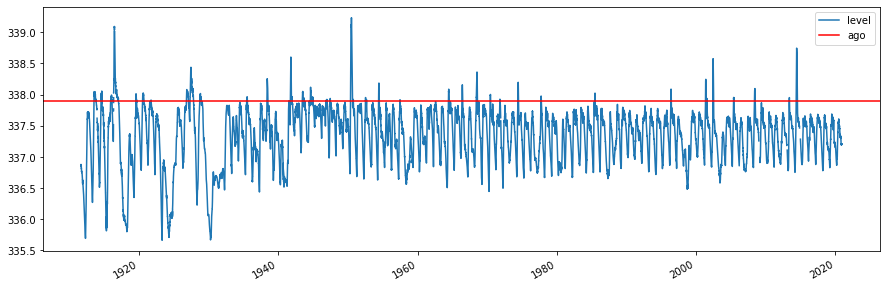

In [77]:
hydat = hydat.Hydat('../../data/Hydat.sqlite3')

# create dataframe with lake levels and years
level = pd.DataFrame(hydat.get_levels("05PB007"), columns=["level"])
level["year"] = level.index.year

ax = level["level"].plot(figsize=figsize)
ax.axhline(AGO, color='r')
ax.legend(["level", "ago"])

display(level.head())

,max_level,flood
year,,
1911,336.880005,False
1912,337.723999,False
1913,338.048004,True
1914,338.057007,True
1915,337.920013,True
...,...,...
2016,337.688995,False
2017,337.683990,False
2018,337.671997,False


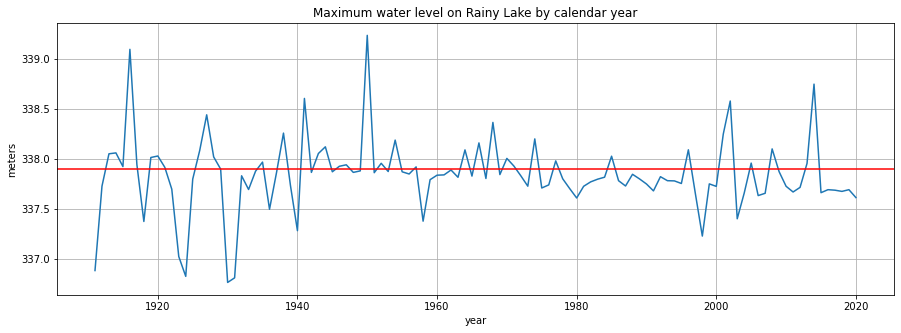

In [78]:
# max levels
X["max_level"] = level.groupby(["year"])["level"].max().to_frame()
X["flood"] = X["max_level"] > AGO
ax = X["max_level"].plot(figsize=figsize, grid=True, ylabel="meters")
ax.set_title("Maximum water level on Rainy Lake by calendar year")
ax.axhline(AGO, color='r')

display(X)

## Precipitation

Precipitation data is extracted from the Daily Summary data for International Falls, MN. 

,PRCP,year,month,doy,water year
DATE,,,,,
1948-01-01,0.0000,1948,1,1,1948.0
1948-01-02,0.0000,1948,1,2,1948.0
1948-01-03,0.1524,1948,1,3,1948.0
1948-01-04,0.0000,1948,1,4,1948.0
1948-01-05,0.0762,1948,1,5,1948.0


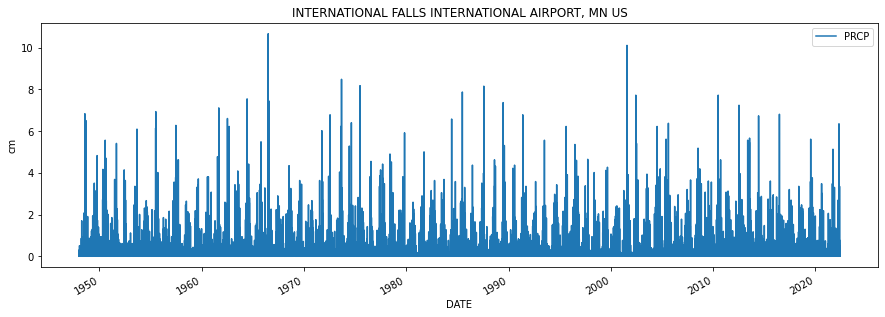

In [79]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd

def read_prcp(datafile="../../data/weather-inl.csv", station="USW00014918"):
    
    df = pd.read_csv(datafile, usecols=["STATION", "NAME", "DATE", "PRCP"])
    
    # select international falls airport station
    df = df[df["STATION"]==station]
    name = df["NAME"].loc[min(df.index)]
    df["PRCP"] = 2.54*df["PRCP"]
        
    # convert to pandas datetime format
    df["DATE"] = pd.to_datetime(df["DATE"])
    
    # select modern data series since 1948
    df = df[df["DATE"] >= dt.datetime(1948, 1, 1)]
    df = df.loc[:, ["DATE", "PRCP"]]
    df = df.dropna()
    
    df['year'] = df['DATE'].dt.year
    df['month'] = df['DATE'].dt.month
    df['doy'] = df['DATE'].dt.dayofyear

    # determine water_year
    for i in df.index:
        yr = df.loc[i, "DATE"].year
        df.loc[i, "water year"] = yr if df.loc[i, "DATE"].month < 10 else yr + 1

    df = df.set_index("DATE")
    df.name = name
    return df

prcp = read_prcp()
prcp.plot(y="PRCP", figsize=figsize, ylabel="cm", title=prcp.name)

display(prcp.head())

### Monthly Precipitation

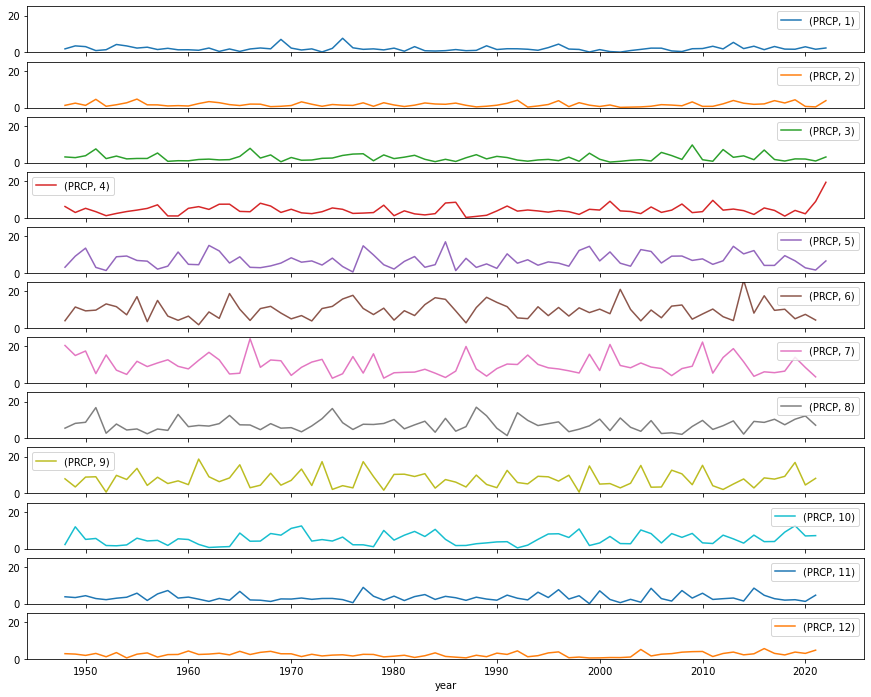

In [80]:
# early season precipitation
monthly_prcp = prcp.groupby(["year", "month"])["PRCP"].sum().to_frame()
monthly_prcp = pd.DataFrame(pd.pivot_table(monthly_prcp, index="year", columns="month"))
monthly_prcp.plot(figsize=(15, 12), subplots=True, layout=(12, 1), ylim=(0, 25));

## Ice Out

                            OLS Regression Results                            
Dep. Variable:                    doy   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     5.018
Date:                Wed, 01 Jun 2022   Prob (F-statistic):             0.0275
Time:                        19:05:31   Log-Likelihood:                -330.65
No. Observations:                  93   AIC:                             665.3
Df Residuals:                      91   BIC:                             670.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        126.6765      1.761     71.919      0.0

,date,doy,n,prediction
year,,,,
1930,1930-05-03,123,0,126.676504
1931,1931-05-05,125,1,126.602424
1932,1932-05-07,128,2,126.528344
1933,1933-05-06,126,3,126.454264
1934,1934-05-06,126,4,126.380184


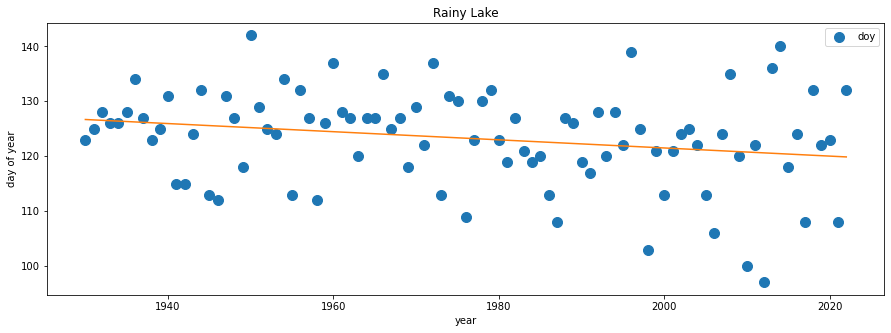

In [81]:
# data file
data_file = "../../data/ice_out_dates_rainy_lake.txt"

# Read .csv file
ice_out = pd.read_csv(data_file, skiprows=1)
ice_out.columns = ["date", "source", "comments"]

# Create a new independent variable that counts years from the first date in the data set
ice_out['date'] = pd.to_datetime(ice_out['date'])
ice_out['year'] = ice_out['date'].dt.year
ice_out['doy'] = ice_out['date'].dt.dayofyear
ice_out['n'] = ice_out['year'] - ice_out['year'][0]

# Drop unneeded columns
ice_out = ice_out.drop(labels='source', axis=1)
ice_out = ice_out.drop(labels='comments', axis=1)

# drop data prior to 1948
ice_out = ice_out.set_index("year")

# regression
import statsmodels.api as sm
X_ice_out = ice_out["n"]
X_ice_out = sm.add_constant(X_ice_out)
y_ice_out = ice_out["doy"]

model = sm.OLS(y_ice_out, X_ice_out).fit()
print(model.summary())
predictions = model.predict(X_ice_out)

ax = ice_out.plot(y="doy", figsize=figsize, style='.', ms=20)
predictions.plot(y="doy", ax=ax)
ax.set_title("Rainy Lake")
ax.set_ylabel("day of year")

ice_out["prediction"] = predictions

display(ice_out.head())

# Ice Out Date as a Predictor of High Water

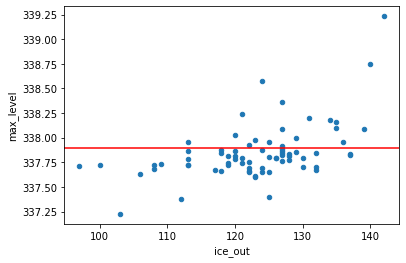

In [82]:
# ice out
X["ice_out"] = ice_out["doy"]
ax = X[X.index >= 1948].plot(x="ice_out", y="max_level", kind="scatter")
ax.axhline(AGO, color='r')

In [83]:
X = X[X.index >= 1949].dropna()
X["flood"] = X["flood"].astype(int)
X

,max_level,flood,ice_out
year,,,
1949,337.877014,0,118.0
1950,339.233002,1,142.0
1951,337.859009,0,129.0
1952,337.953003,1,125.0
1953,337.871002,0,124.0
...,...,...,...
2016,337.688995,0,124.0
2017,337.683990,0,108.0
2018,337.671997,0,132.0


https://en.wikipedia.org/wiki/F-score

In [84]:
# use d as a predictor of high water events
def F(thresh):
    N = X[X["ice_out"] < thresh]
    Y = X[X["ice_out"] >= thresh]
    
    TN = (1 - N["flood"]).sum()
    FN = N["flood"].sum()
    
    FP = (1 - Y["flood"]).sum()
    TP = Y["flood"].sum()
    
    return ((TP)/(TP + 0.5*(FP + FN)))
    
    
for thresh in range(90, 145): 
    print(thresh, F(thresh))
    
    

90 0.4175824175824176
91 0.4175824175824176
92 0.4175824175824176
93 0.4175824175824176
94 0.4175824175824176
95 0.4175824175824176
96 0.4175824175824176
97 0.4175824175824176
98 0.4222222222222222
99 0.4222222222222222
100 0.4222222222222222
101 0.42696629213483145
102 0.42696629213483145
103 0.42696629213483145
104 0.4318181818181818
105 0.4318181818181818
106 0.4318181818181818
107 0.4367816091954023
108 0.4367816091954023
109 0.4470588235294118
110 0.4523809523809524
111 0.4523809523809524
112 0.4523809523809524
113 0.4578313253012048
114 0.46153846153846156
115 0.46153846153846156
116 0.46153846153846156
117 0.46153846153846156
118 0.4675324675324675
119 0.4864864864864865
120 0.5070422535211268
121 0.5074626865671642
122 0.5
123 0.5084745762711864
124 0.5
125 0.5
126 0.5
127 0.5217391304347826
128 0.46153846153846156
129 0.5
130 0.47058823529411764
131 0.5
132 0.45161290322580644
133 0.5
134 0.5
135 0.4444444444444444
136 0.32
137 0.25
138 0.2727272727272727
139 0.272727272727272

In [86]:
def cm(thresh):
    N = X[X["ice_out"] < thresh]
    Y = X[X["ice_out"] >= thresh]
    
    TN = (1 - N["flood"]).sum()
    FN = N["flood"].sum()
    
    FP = (1 - Y["flood"]).sum()
    TP = Y["flood"].sum()
    
    print(f"TP = {TP}    FN = {FN}")
    print(f"FP = {FP}    TN = {TN}")
    
    return ((TP)/(TP + 0.5*(FP + FN)))

cm(120)
    

TP = 18    FN = 1
FP = 34    TN = 19


0.5070422535211268

## Creating a Feature Matrix

In [127]:
X = pd.DataFrame()

# ice out doy
X["ice out"] = ice_out["doy"] - ice_out["prediction"]
X = X[X.index >= start]
X = X[X.index <= end]

# early season precipitation
n_months = 5
monthly_prcp = prcp.groupby(["year", "month"])["PRCP"].sum().to_frame()
monthly_prcp = pd.DataFrame(pd.pivot_table(monthly_prcp, index="year", columns="month"))
X["spring prcp"] = sum([monthly_prcp[("PRCP", k)] for k in range(1, n_months + 1)])

# april 1st water level
X["april level"] = [level.loc[d, "level"] for d in [datetime.datetime(yr, 4, 1) for yr in X.index]]

# max level
X["max level"] = level.groupby(["year"])["level"].max().to_frame()
X["flood"] = X["max level"] > AGO

# regressor and features
X = X[X.index <= end]
display(X)

,ice out,spring prcp,april level,max level,flood
year,,,,,
1948,-0.102807,6.10,337.091003,337.862000,False
1949,-8.992281,8.15,337.166992,337.877014,False
1950,15.118246,10.54,336.894989,339.233002,True
1951,2.228772,7.59,336.752014,337.859009,False
1952,-1.660702,2.69,336.705994,337.953003,True
...,...,...,...,...,...
2016,4.412982,7.80,337.078003,337.688995,False
2017,-11.476491,6.62,336.893005,337.683990,False
2018,12.634035,6.10,336.792999,337.671997,False


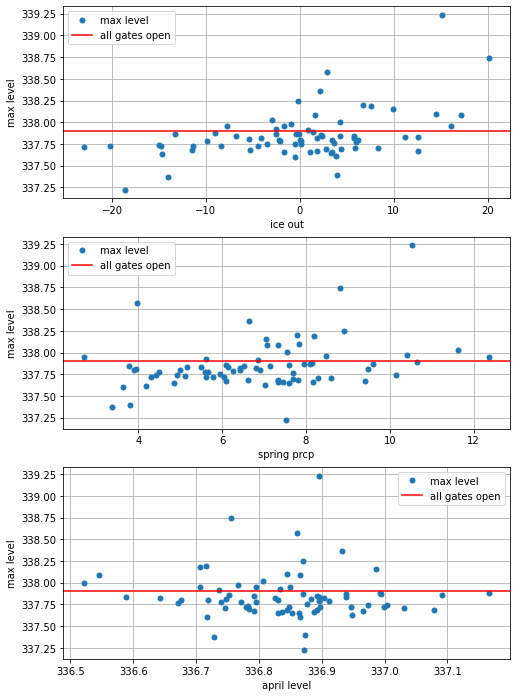

In [45]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

X.plot(x="ice out", y="max level", style='.', ms=10, ax=ax[0], grid=True)
X.plot(x="spring prcp", y="max level", style='.', ms=10, ax=ax[1], grid=True)
X.plot(x="april level", y="max level", style='.', ms=10, ax=ax[2], grid=True)

for a in ax:
    a.axhline(AGO, color='r')
    a.legend(["max level", "all gates open"])
    a.set_ylabel("max level")

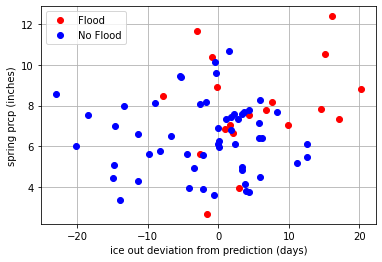

In [46]:
fig, ax = plt.subplots(1, 1)

X[X["flood"]].plot(x="ice out", y="spring prcp", style='.', ax=ax, color='r', ms=12)
X[X["flood"]==False].plot(x="ice out", y="spring prcp", style='.', ax=ax, color='b', ms=12)

ax.set_xlabel("ice out deviation from prediction (days)")
ax.set_ylabel("spring prcp (inches)")
ax.legend(["Flood", "No Flood"])
ax.grid(True)

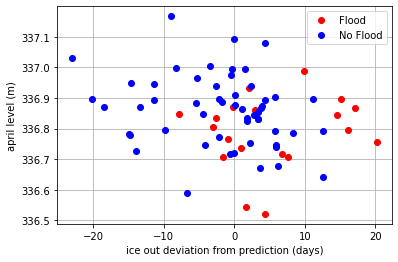

In [47]:
fig, ax = plt.subplots(1, 1)

X[X["flood"]].plot(x="ice out", y="april level", style='.', ax=ax, color='r', ms=12)
X[X["flood"]==False].plot(x="ice out", y="april level", style='.', ax=ax, color='b', ms=12)

ax.set_xlabel("ice out deviation from prediction (days)")
ax.set_ylabel("april level (m)")
ax.legend(["Flood", "No Flood"])
ax.grid(True)

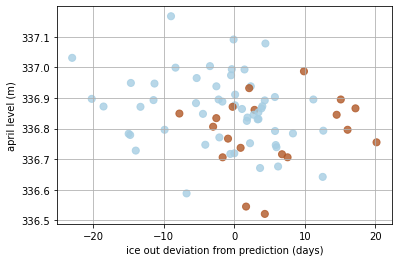

In [144]:
fig, ax = plt.subplots(1, 1)

ax.scatter(X["ice out"], X["april level"], c=X["flood"], s=50, cmap=plt.cm.Paired, alpha=0.8)
ax.set_xlabel("ice out deviation from prediction (days)")
ax.set_ylabel("april level (m)")
ax.grid(True)

## Ice Out as a Predictor of High Water 

In [154]:
X["flood"] = X["flood"].astype(float)
X["one"] = 1
X

,ice out,spring prcp,april level,max level,flood,one
year,,,,,,
1948,-0.102807,6.10,337.091003,337.862000,0.0,1
1949,-8.992281,8.15,337.166992,337.877014,0.0,1
1950,15.118246,10.54,336.894989,339.233002,1.0,1
1951,2.228772,7.59,336.752014,337.859009,0.0,1
1952,-1.660702,2.69,336.705994,337.953003,1.0,1
...,...,...,...,...,...,...
2016,4.412982,7.80,337.078003,337.688995,0.0,1
2017,-11.476491,6.62,336.893005,337.683990,0.0,1
2018,12.634035,6.10,336.792999,337.671997,0.0,1


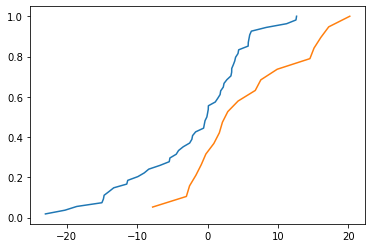

In [186]:
def cumdist(x):
    x = sorted(np.array(x))
    p = np.cumsum(np.array([x, np.ones(len(x))]).T, axis=0)[:, 1]/len(x)
    return x, p

x, p = cumdist(X[X["flood"]==False]["ice out"])
y, q = cumdist(X[X["flood"]==True]["ice out"])
plt.plot(x, p, y, q)

        
    

        ice out  flood  one
year                       
2012 -23.029123    0.0    1
2010 -20.250175    0.0    1
1998 -18.576491    0.0    1
1976 -15.008070    0.0    1
1987 -14.792281    0.0    1
2006 -14.692281    0.0    1
1958 -13.997544    0.0    1
1955 -13.329123    0.0    1
2017 -11.476491    0.0    1
1973 -11.339649    0.0    1
1986  -9.902807    0.0    1
1949  -8.992281    0.0    1
2000  -8.355439    0.0    1
1969  -6.781754    0.0    1
1963  -5.444912    0.0    1
1991  -5.350175    0.0    1
1981  -4.455439    0.0    1
1984  -4.123860    0.0    1
1990  -3.460702    0.0    1
1953  -2.550175    0.0    1
1983  -2.234386    0.0    1
1993  -2.129123    0.0    1
2015  -1.697544    0.0    1
1980  -0.565965    0.0    1
1999  -0.465965    0.0    1
2009  -0.360702    0.0    1
1948  -0.102807    0.0    1
1967  -0.002807    0.0    1
1995   0.091930    0.0    1
1959   0.112982    0.0    1
2004   1.086667    0.0    1
1962   1.444561    0.0    1
1965   1.776140    0.0    1
2011   1.860351    0

<AxesSubplot:xlabel='ice out'>

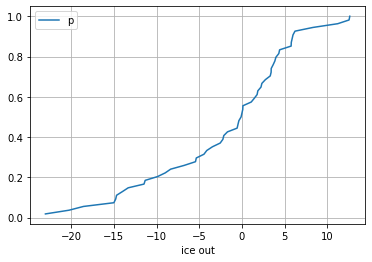

In [166]:
f = X[X["flood"]==False]
a = f[["ice out", "flood", "one"]]
a = a.sort_values(["ice out"])
print(a)
a["p"] = a["one"].cumsum()/len(a)
a.plot(x="ice out", y="p", grid=True)

## Logit Regression - sklearn

https://towardsdatascience.com/the-perfect-recipe-for-classification-using-logistic-regression-f8648e267592

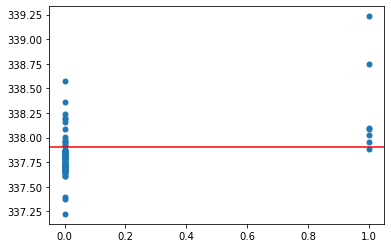

In [98]:
from sklearn.model_selection import train_test_split

X_select = np.array(X[["ice out", "april level", "spring prcp"]])
y_select = np.array(X["flood"]).astype(float)

X_train, X_test, y_train, y_test = train_test_split(X_select, y_select, test_size = .2)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

import matplotlib.pyplot as plt

predictions = model.predict(X_select)
plt.plot(predictions, np.array(X["max level"]), '.', ms=10)
model.predict(X_select)

ax = plt.gca()
ax.axhline(AGO, color='r')

## Support Vector Machine

0.7


array([ 6,  7, 15, 17, 26, 27, 30, 32, 38,  0,  3,  5, 11, 14, 18, 31, 39,
       40], dtype=int32)

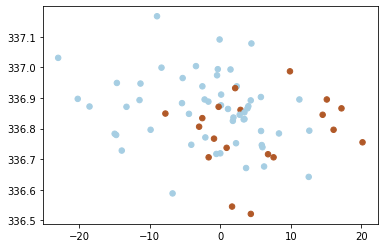

In [124]:
from sklearn.model_selection import train_test_split
import sklearn.inspection
from sklearn import svm
import matplotlib.pyplot as plt


X_select = np.array(X[["ice out", "april level"]]) #, "spring prcp"]])
y_select = np.array(X["flood"]).astype(float)

X_train, X_test, y_train, y_test = train_test_split(X_select, y_select, test_size = .4)


clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))


#predictions = clf.predict(X_select)
#plt.plot(predictions, np.array(X["max level"]), '.', ms=10)
#model.predict(X_select)

#ax = plt.gca()
#ax.axhline(AGO, color='r')

plt.scatter(X_select[:, 0], X_select[:, 1], c=y_select, s=30, cmap=plt.cm.Paired)

clf.support_

## Logit Regression

In [40]:
import numpy as np

ytrain = np.array(X["flood"]).astype(float)
Xtrain = np.array(X[["ice out", "spring prcp", "april level"]])
Xtrain = np.array(X[["ice out", "spring prcp"]])
Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.463171
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   73
Model:                          Logit   Df Residuals:                       70
Method:                           MLE   Df Model:                            2
Date:                Tue, 31 May 2022   Pseudo R-squ.:                  0.1922
Time:                        10:59:28   Log-Likelihood:                -33.811
converged:                       True   LL-Null:                       -41.854
Covariance Type:            nonrobust   LLR p-value:                 0.0003215
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6406      1.248     -2.918      0.004      -6.086      -1.195
x1             0.1172      0.045      2.606      0.009       0.029       0.205
x2             0.3341      0.163      2.048      0.041       0.014       0.654
==============================================================================
"""

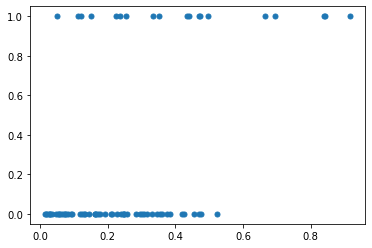

In [41]:
import matplotlib.pyplot as plt

predictions = log_reg.predict(Xtrain)
plt.plot(predictions, ytrain, '.', ms=10)

In [42]:
ytrain

array([0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0.])